In [1]:
import numpy as np
import tensorflow as tf
from src.util import plot_voxel

# import vae
from src.vae import vae_model

2024-04-05 12:29:48.365795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 12:29:54.869669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Stage 3

_Build the full reconstruction network architecture_

1. Load the VAE $\Psi : \mathbf{z} \rightarrow \hat{\gamma}$
2. Load the mapper $\Gamma : \varphi \rightarrow \mathbf{z}$
3. Load the mapper $\Pi : \varphi \rightarrow \mathbf{m}$

## 1. Load the VAE $\Psi$

In [2]:
vae = vae_model()
vae.load_weights("models/vae.weights.h5")
vae.summary()

2024-04-05 12:30:07.187787: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │         6,935 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │         9,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,354 (63.88 KB)

 Trainable params: 16,292 (63.64 KB)

 Non-trainable params: 62 (248.00 B)

In [3]:
tmp = np.load("models/vae_testdata.npz", allow_pickle=True)
X_test, r_test = tmp["X_test"], tmp["r_test"]
print(X_test.shape, r_test.shape)

(2073, 32, 32, 32) (2073,)


In [4]:
_, _, z_pred = vae.encoder.predict(X_test)
gamma_pred = vae.decoder.predict(z_pred)

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step


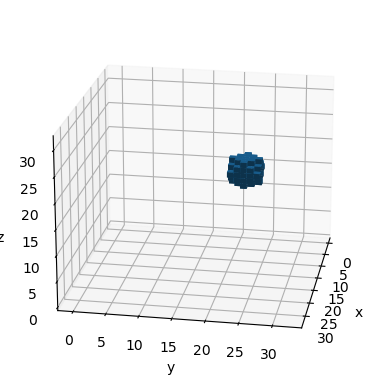

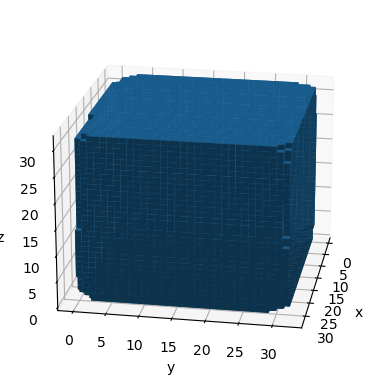

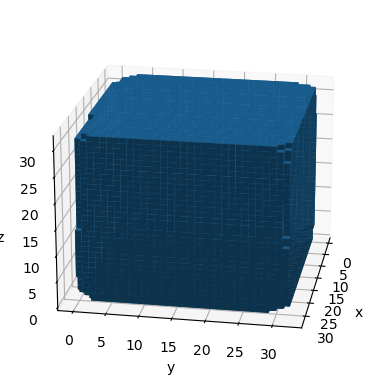

----------


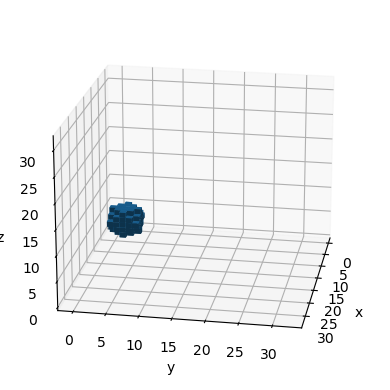

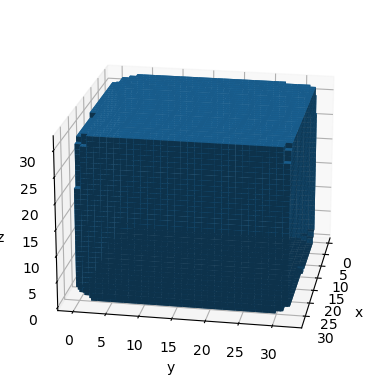

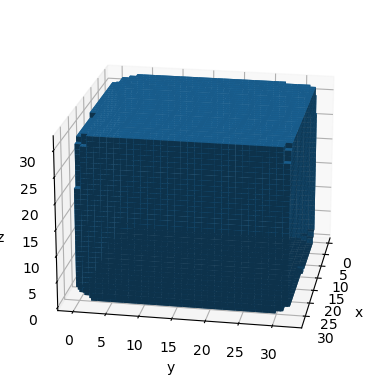

----------


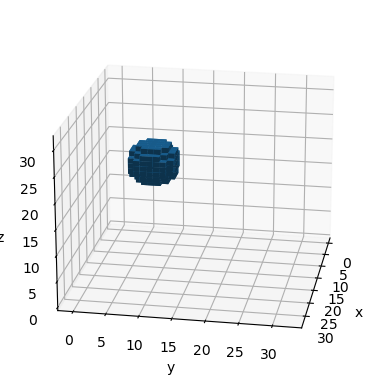

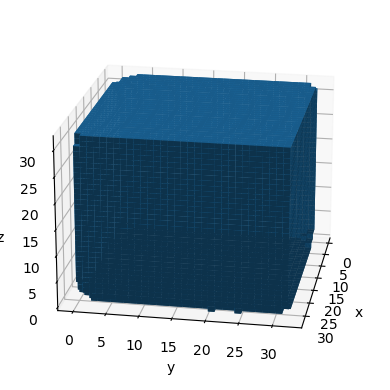

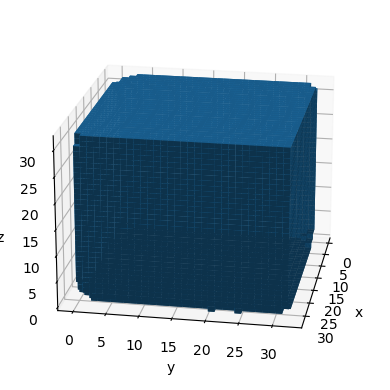

----------


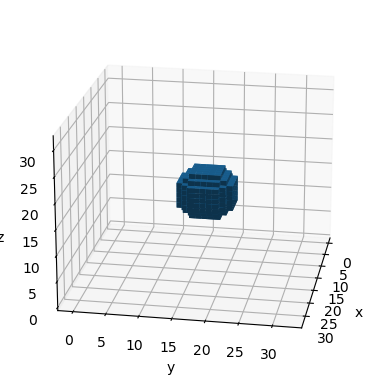

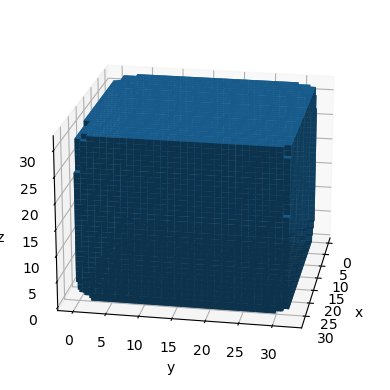

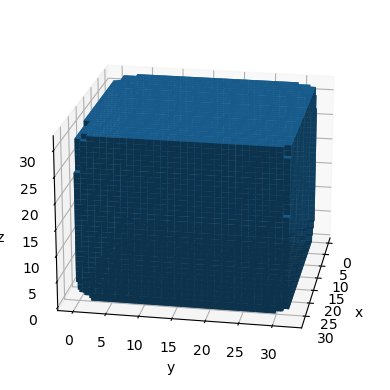

----------


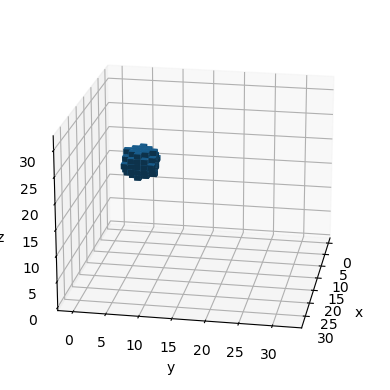

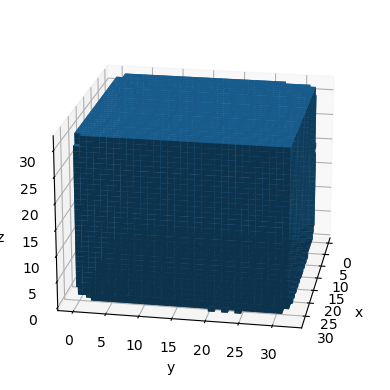

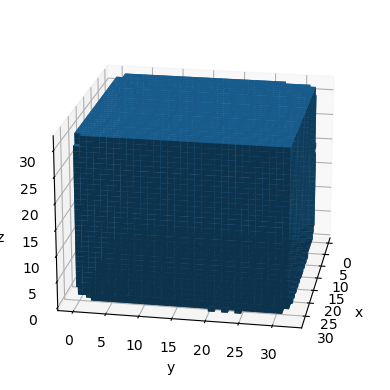

----------


In [5]:
for rdn in np.random.randint(low=0, high=X_test.shape[0], size=5):
    plot_voxel(X_test[rdn, ...])
    plot_voxel(np.round(gamma_pred[rdn, :, :, :, 0]))
    plot_voxel(np.round(np.abs(gamma_pred[rdn, :, :, :, 0])))
    print("----------")